# Module 2 Summary Project

In [2]:
import pandas as pd #importing my necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
import requests
from lib import Weather
from lib import mongoinsert
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
%load_ext autoreload # Auto updating the libraries I've imported so any changes made to lib.py make it into my code
%autoreload 2

ModuleNotFoundError: No module named "autoreload # Auto updating the libraries I've imported so any changes made to lib"

In [6]:
con = sqlite3.connect('database.sqlite') # Connecting to the sqlite file
cur = con.cursor()

In [7]:
table_names = ['Matches', 'Teams', 'Unique_Teams', 'Teams_in_matches'] # Getting the name of each sql table

In [8]:
def make_df(table_name): # Takes the name of a table and makes a pandas dataframe from it
    return pd.read_sql_query(f"""SELECT * FROM {table_name}""", con)

In [9]:
dfs = list(map(lambda x: make_df(x), table_names)) # Applying the above function to each of the table names

In [10]:
matches_df = dfs[0] # Naming dbs for clarity
teams_df = dfs[1]
unique_df = dfs[2]
teams_in_matches_df = dfs[3] 

In [117]:
matches_df = matches_df.loc[((matches_df['Div'] == 'D1') | (matches_df['Div'] == 'D2'))] 
matches_2011 = matches_df.loc[matches_df['Season']==2011] # Getting only German games and getting the 2011-12 season

In [12]:
matches_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [119]:
matches_2011.loc[matches_2011["FTR"] == 'H', "home_win"] = True # Making new binary columns for wins
matches_2011.loc[matches_2011["FTR"] == 'A', "away_win"] = True
matches_2011.away_win = matches_2011.away_win.fillna(False)
matches_2011.home_win = matches_2011.home_win.fillna(False)

In [89]:
dates = list(matches_2011.Date) # Getting a list of the match dates

In [16]:
berlin_coordinates = (52.520008, 13.404954) # Coordinates to pass into the api requests

In [17]:
weather = Weather() # Instantiating weather object

In [18]:
weather_test = weather.api_test(berlin_coordinates) # Testing the api

Success!


In [19]:
weather.getweather(berlin_coordinates, dates) # Getting weather data from the API

In [22]:
weather_backup = open('weather_backup.txt','w') # Making a backup incase I exceed my API request limit
for weather_day in weather.weather_days:
    weather_backup.write(str(weather_day))

In [23]:
weather.rainmaker() # Method for getting a list of bool values for whether or not it rained on a date

In [24]:
rains = weather.rains

In [123]:
matches_2011['rain'] = rains # Adding the list as a column to the DF

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [125]:
# Setting up binary columns for wins in rainy conditions
matches_2011.loc[((matches_2011['home_win'] == True) & (matches_2011['rain'] == True)), 'rain_home_win'] = True
matches_2011.loc[((matches_2011['away_win'] == True) & (matches_2011['rain'] == True)), 'rain_away_win'] = True
matches_2011.rain_home_win = matches_2011.rain_home_win.fillna(False)
matches_2011.rain_away_win = matches_2011.rain_away_win.fillna(False)

In [128]:
# Grouping and aggregating goal and wins
matches_2011_home_sum = matches_2011.groupby('HomeTeam').sum()
matches_2011_home_sum = matches_2011_home_sum.rename(columns = {'home_win': 'wins', 'away_win': 'losses', 'rain_home_win': 'rain_wins', 'rain_away_win': 'rain_losses', 'FTHG': 'goals'})
matches_2011_away_sum = matches_2011.groupby('AwayTeam').sum()
matches_2011_away_sum = matches_2011_away_sum.rename(columns = {'away_win': 'wins', 'home_win': 'losses', 'rain_away_win': 'rain_wins', 'rain_home_win': 'rain_losses', 'FTAG': 'goals'})

In [129]:
total_2011 = matches_2011_home_sum + matches_2011_away_sum
total_2011.drop(columns=['FTAG', 'FTHG', 'Match_ID', 'Season'], axis = 1, inplace=True)

In [130]:
total_2011['rain_win_percent'] = round(total_2011.rain_wins / (total_2011.rain_wins + total_2011.rain_losses) * 100, 1)

In [132]:
total_2011

,goals,losses,rain,rain_losses,rain_wins,wins,rain_win_percent
HomeTeam,,,,,,,
Aachen,30,15.0,2.0,0.0,1.0,6.0,100.0
Augsburg,36,12.0,0.0,0.0,0.0,8.0,NaN
Bayern Munich,77,7.0,3.0,1.0,2.0,23.0,66.7
Bochum,41,17.0,2.0,0.0,1.0,10.0,100.0
Braunschweig,37,9.0,2.0,0.0,1.0,10.0,100.0
Cottbus,30,15.0,3.0,1.0,1.0,8.0,50.0
Dortmund,80,3.0,1.0,0.0,0.0,25.0,NaN
Dresden,50,13.0,1.0,0.0,0.0,12.0,NaN
Duisburg,42,15.0,3.0,2.0,0.0,10.0,0.0


In [137]:
total_2011_json = total_2011.to_dict('index') # Making a dictionary format to enter into my MongoDB

In [152]:
mongoinsert('mydb', 'german_team_totals_2011', total_2011_json) # Inserting these changes in my MongoDB local server

Text(0.5, 0, 'Team Name')

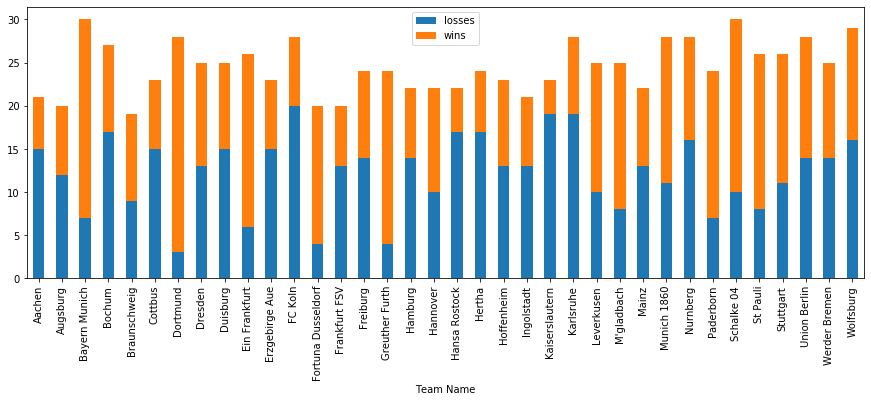

In [145]:
ax = totals_2011.plot(y = ['losses', 'wins'], kind = 'bar', stacked = True, figsize=(15, 5))
ax.set_xlabel("Team Name") # A figure that I can't seem to get into my MongoDB

In [146]:
fig = ax.get_figure()
fig.savefig("team_wins_losses_2011.png") # Saving this figure